In [1]:
import os

import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from IPython.display import clear_output
from torch.utils.data.sampler import SubsetRandomSampler

from preprocess import (FermiDataset, RandomCrop, ToTensor,
                       OneHotEncoding, calculate_distance)
%matplotlib inline

plt.style.use('ggplot')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Data preprocessing

In [2]:
def show_fermi(ax, i, image, mask):
    ax[0][i].imshow(image.reshape(image.shape[:2]))
    ax[1][i].imshow(mask.reshape(image.shape[:2]))
    
def draw_plots(lenght, dset, titles):
    _, ax = plt.subplots(2, lenght, figsize=(15, 15))
    indices = np.random.choice(range(len(dset)), replace=False, size=lenght)
    for ix, i in enumerate(indices):
        sample = dset[i]
        plt.tight_layout()
        ax[0][ix].grid()
        ax[0][ix].set_title(titles[0] + ' #{}'.format(i))
        ax[1][ix].grid()
        ax[1][ix].set_title(titles[1] + ' #{}'.format(i))

        show_fermi(ax, ix,  *sample)
        plt.subplots_adjust(wspace=0.1, hspace=-0.6)

In [3]:
data_transform = transforms.Compose([
        RandomCrop(40),
        OneHotEncoding(2),
        ToTensor()
])
path = '/notebooks/anton/course/data'
dset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                    points_path=os.path.join(path, 'train_data/y'), transform=data_transform)

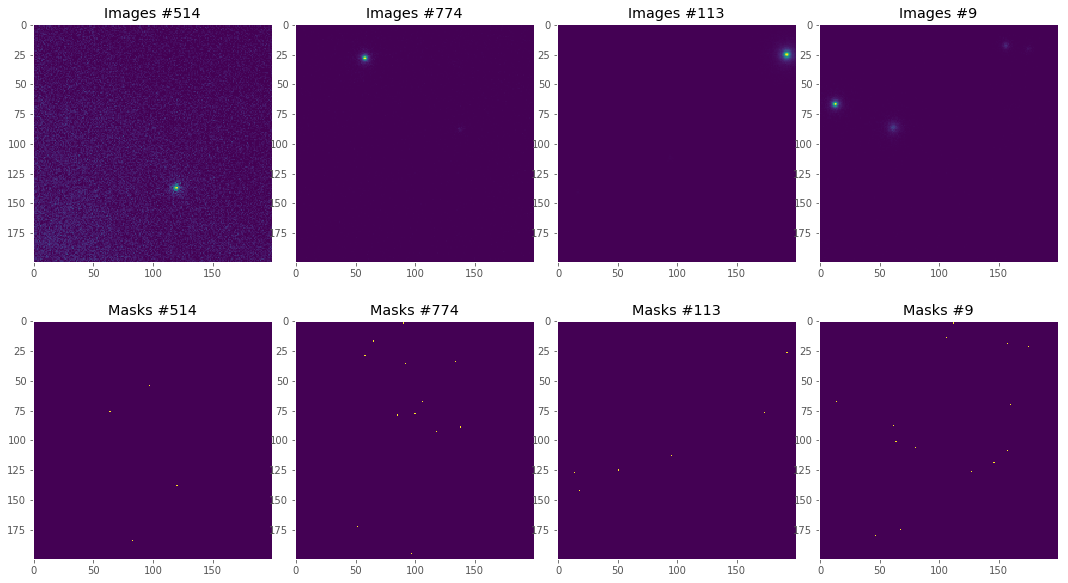

In [4]:
data_transform = transforms.Compose([
        RandomCrop(50),
        ToTensor()
])

dset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                    points_path=os.path.join(path, 'train_data/y'))
draw_plots(4, dset, ['Images', 'Masks'])

In [5]:
SIZE = 20
BATCH_SIZE = 30
data_transform = transforms.Compose([
        RandomCrop(SIZE),
        OneHotEncoding(2),
        ToTensor()
])

train_dataset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                             points_path=os.path.join(path, 'train_data/y'),
                             transform=data_transform)
test_dataset = FermiDataset(images_path=os.path.join(path, 'test_data/x'),
                            points_path=os.path.join(path, 'test_data/y'),
                            transform=data_transform)

data_loader = {phase: torch.utils.data.DataLoader(dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True,
                                                  num_workers=4)
               for phase, dataset in zip(['train', 'test'], [train_dataset, test_dataset])}

dataset_sizes = {phase: len(dataset) for phase, dataset in zip(['train', 'test'], 
                                                               [train_dataset, test_dataset])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model initialization

In [6]:
class ConvNet(nn.Module):
    def __init__(self, device):
        self.device = device
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2).to(self.device)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1).to(self.device)
#         self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1).to(self.device)
#         self.conv4 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv6 = nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1).to(self.device)

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs)).to(self.device)
#         x = F.relu(self.conv2(x)).to(self.device)
#         x = F.relu(self.conv3(x)).to(self.device)
#         x = F.relu(self.conv4(x)).to(self.device)
        x = F.relu(self.conv5(x)).to(self.device)
        x = self.conv6(x).to( self.device)
        return x

### Training process

In [7]:
def plot_stats(loss, acc, name):
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(loss)
    ax[0].set_title(name + ' Loss')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Loss')
    ax[1].plot(acc)
    ax[1].set_title(name + ' Distance')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Distance')
    plt.show()

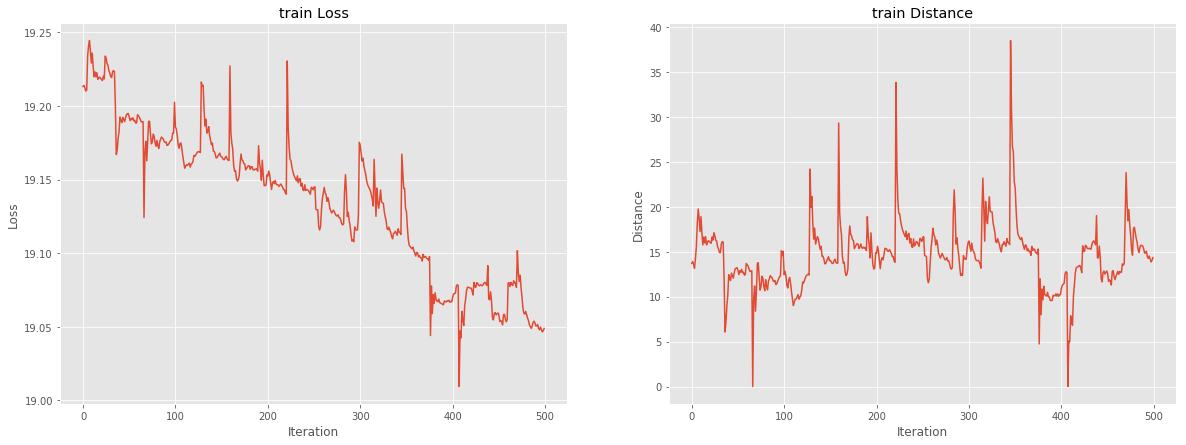

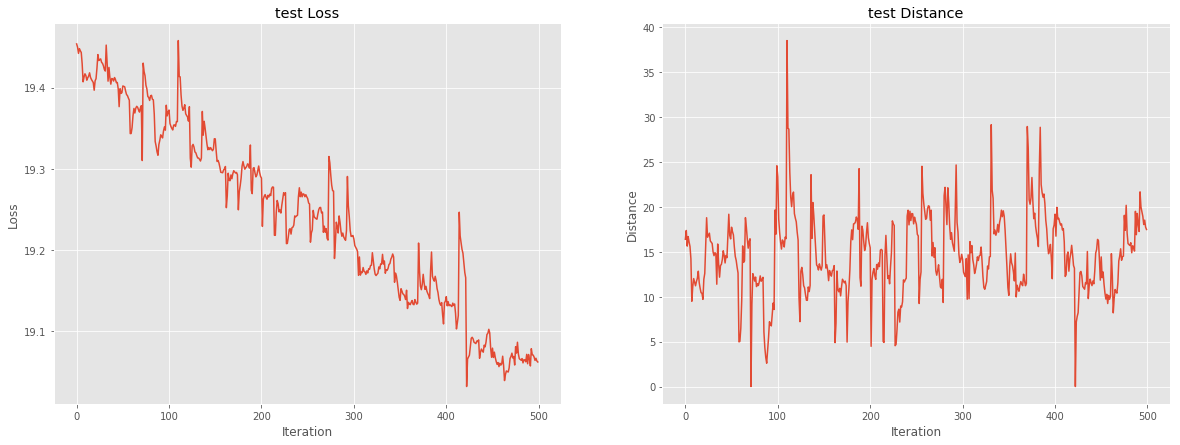

test Loss: 19.0667 Distance: 18.6692


In [8]:
from tqdm import tqdm

model = ConvNet(device=device)
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)#optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.001)#
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1., 25.])).to(device)
num_epochs = 150
n_last = 500
sigm = torch.nn.Sigmoid()

global_loss_train = []
global_acc_train = []

global_loss_test = []
global_acc_test = []

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
#             scheduler.step()
            model.train()
        else:
            model.eval()

        running_loss = []
        running_metrics = []

        for num_iter, (inputs, labels) in enumerate(data_loader[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            if inputs.shape[0] != BATCH_SIZE:
                continue

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                outputs = outputs.transpose(3, 1)
                preds = sigm(outputs)

                outputs = outputs.to(device)
                labels = labels.to(device)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                class_pred = (preds[:, :, :, 1] > 0.5).to(torch.uint8)
                class_true = (labels[:, :, :, 1]).to(torch.uint8)

            running_loss.append(loss.item() * inputs.size(0))
            running_metrics.append(np.mean([calculate_distance(np.array(np.where(class_true[i].cpu())).T,
                                                           np.array(np.where(class_pred[i].cpu())).T)
                                        for i in range(BATCH_SIZE)]))
            
            if phase == 'train':
                global_loss_train.append(np.mean(running_loss))
                global_acc_train.append(np.mean(running_metrics))
            
            if phase == 'test':
                global_loss_test.append(np.mean(running_loss))
                global_acc_test.append(np.mean(running_metrics))

        clear_output()

        plot_stats(global_loss_train[-n_last: ], global_acc_train[-n_last: ], 'train')
        plot_stats(global_loss_test[-n_last: ], global_acc_test[-n_last: ], 'test')
        
        epoch_loss = np.mean(global_loss_train[-num_iter: ] if phase == 'train' else global_loss_test[-num_iter: ])
        epoch_acc = np.mean(global_acc_train[-num_iter: ] if phase == 'train' else global_acc_test[-num_iter: ])

        print('{} Loss: {:.4f} Distance: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        # deep copy the model
#         if phase == 'test' and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

### Prediction

In [15]:
def list_crop(image, size):
    imgs = []
    for i in range(0, 200, size):
        for j in range(0, 200, size):
            imgs.append(image[:, i : i+size, j : j+size].reshape(-1, 1, size, size))
    return imgs

def assemble_imgs(list_imgs, out_size):
    image = np.zeros((out_size))
    num_img = 0
    for i in range(0, out_size[0], size):
        for j in range(0, out_size[1], size):
            image[i : i+size, j : j+size] = list_imgs[num_img]
            num_img += 1
    return image

In [21]:
pred_transform = transforms.Compose([
        OneHotEncoding(2),
        ToTensor()
])
predict_dataset = FermiDataset(images_path=os.path.join(path, 'test_data/x'),
                               points_path=os.path.join(path, 'test_data/y'),
                               transform=pred_transform)

pred_loader = torch.utils.data.DataLoader(predict_dataset,
                                          batch_size=1, shuffle=True,
                                          num_workers=4)

In [22]:
len_pred = 10
size = 20
list_preds = []
list_labels = []

model.eval()
for ix, (images, labels) in enumerate(pred_loader):
    crop_images = [list_crop(image, size) for image in images][0]
    model.eval()
    result = []
    for img in crop_images:
        with torch.no_grad():
            inputs = img.to(device)
            outputs = model(inputs).transpose(3, 1)

            sigm = torch.nn.Sigmoid()
            result.append(sigm(outputs).cpu()[:, :, :, 1] > .5)
    list_preds.append(assemble_imgs(result, (200, 200)))
    list_labels.append(labels[:, :, :, 1])
    if ix == len_pred:
        break

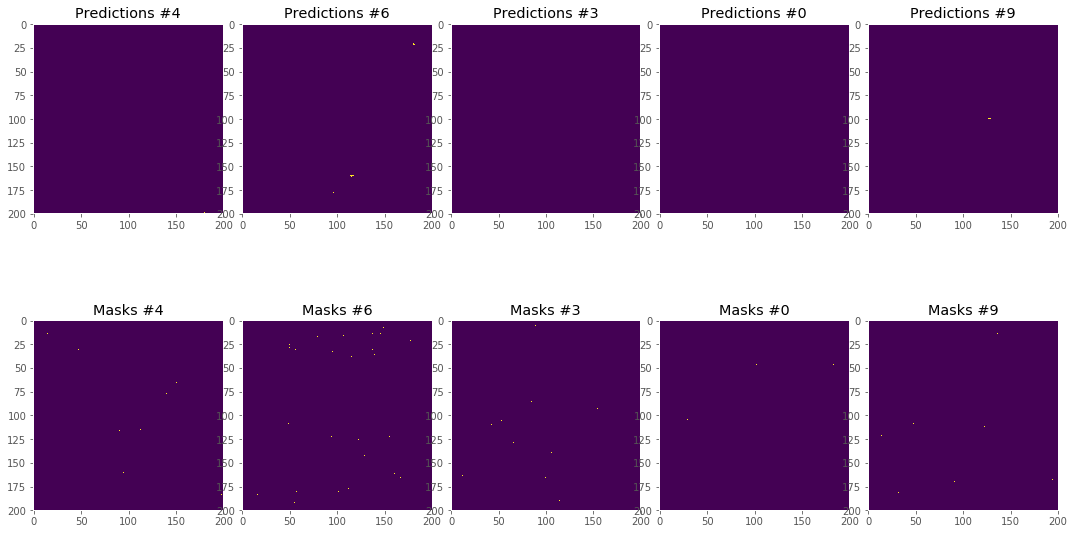

In [24]:
q = np.random.choice(range(len(list_preds)))
data = list(zip(list_preds, list_labels))
draw_plots(5, data, ['Predictions', 'Masks'])